# 0. Imports

#### For installing EAZY-py and necessary (filter and template) files, please refer to the websites below.

* **[https://github.com/gbrammer/eazy-py](https://github.com/gbrammer/eazy-py)**
    
* **[https://github.com/gbrammer/eazy-photoz/](https://github.com/gbrammer/eazy-photoz/)**

In [1]:
# Imports
import eazy

# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib', 'astropy', 'eazy']:#, 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print(f"{module:>20} : {mod.__version__}")

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib notebook
from astropy.io import fits
import pickle
import tqdm

import warnings
warnings.filterwarnings("ignore")

Wed Jul 19 00:31:15 2023

3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]

               numpy : 1.24.3
               scipy : 1.9.1
          matplotlib : 3.5.2
             astropy : 5.2.1
                eazy : 0.6.3


In [2]:
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    os.environ['EAZYCODE'] = "/data01/jhlee/Downloads/eazy-photoz/"  # the path where eazy-photoz was downloaded

# 1. Set filters
#### (HST/ACS, HST/WFC3-IR, and JWST/NIRCam)

In [3]:
id_flt_hst  = [233, 236, 239, 202, 203, 205]    # from 'FILTER.RES.latest.info' file
id_flt_jwst = [364, 365, 366, 375, 376, 383, 377]    # from 'FILTER.RES.latest.info' file
bands_hst  = ['f435w', 'f606w', 'f814w',    # HST/ACS
              'f105w', 'f125w', 'f160w']    # HST/WFC3-IR
bands_jwst = ['f115w', 'f150w', 'f200w',    # JWST/NIRCam short wavelength channel
              'f277w', 'f356w', 'f410m', 'f444w']    # JWST/NIRCam long wavelength channel

### Creating ``*.translate`` file

#### `*.translate` file is used to provide the filter information in the input flux catalog.

In [4]:
def create_translate(band_name, band_id, out):
    with open(out, "w") as fw:
        for i in range(len(band_name)):
            fw.write(band_name[i]+f"_tot_1   F{band_id[i]:d}\n")
            fw.write(band_name[i]+f"_etot_1  E{band_id[i]:d}\n")

create_translate(bands_hst+bands_jwst, id_flt_hst+id_flt_jwst, "total.translate")

# 2. Define functions for running EAZY-py

### Input parameters to set up

In [5]:
def eazypy_input(catalog, dir_output, output_file,
                 filters="FILTER.RES.latest", temp_file="carnall_sfhz_13.param", #temp_combo="a",
                 wave_file="lambda.def", temperr_file="template_error_cosmos2020.txt",
                 # laf_file=dir_temp+"LAFcoeff.txt", dla_file=dir_temp+"DLAcoeff.txt",
                 apply_prior=False, prior_file="prior_F160W_TAO.dat", prior_filter=365,
                 fix_zspec=False, zmin=0.01, zmax=12.0, zstep=0.01):#, H0=68.4, Omega_M=0.3, Omega_L=0.7):

    params = {}
    params['FILTERS_RES']       = filters
    params['TEMPLATES_FILE']    = temp_file  #'carnall_sfhz_13.param'
    params['WAVELENGTH_FILE ']  = wave_file
    params['TEMP_ERR_FILE']     = temperr_file

    params['TEMP_ERR_A2']       = 1.0
    params['SYS_ERR']           = 0.05

    params['MW_EBV']            = 0.012
    params['CAT_HAS_EXTCORR']   = True

    params['CATALOG_FILE']      = catalog  #"EAZY_INPUT/flux_EAZY_total_run1.cat"

    # dir_out = "EAZY_OUTPUT"
    if not os.path.exists(dir_output):
        os.system("mkdir "+dir_output)
    params['OUTPUT_DIRECTORY']  = dir_output
    params['MAIN_OUTPUT_FILE']  = output_file  #'output.eazypy'

    params['APPLY_PRIOR']       = apply_prior  #True
    params['PRIOR_FILE']        = prior_file  #"prior_F160W_TAO.dat"
    params['PRIOR_FILTER']      = prior_filter  #365
    params['PRIOR_ABZP']        = 23.9
    params['PRIOR_FLOOR']       = 0.01

    params['FIX_ZSPEC']         = fix_zspec
    params['Z_MIN']             = zmin  #0.05
    params['Z_MAX']             = zmax  #12.0
    params['Z_STEP']            = zstep  #0.005
    params['Z_STEP_TYPE']       = 1

    return params

### Running eazy-py

In [6]:
def start_eazypy(param_file, params, NITER=10, translate_file="zphot.translate",
                 output_prefix="output.eazypy", dir_output="EAZY_OUTPUT",
                 zeropoint_file=None):

    pred = eazy.photoz.PhotoZ(param_file=param_file,
                              translate_file=translate_file,
                              zeropoint_file=zeropoint_file, 
                              params=params,
                              load_prior=True, load_products=False)
 
    if (zeropoint_file == None):
        NBIN = np.minimum(pred.NOBJ//100, 180)
        pred.param.params['VERBOSITY'] = 1.
        for i in range(NITER):
            print('Iteration: ', i)
            sn = pred.fnu/pred.efnu
            clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
            pred.iterate_zp_templates(idx=pred.idx[clip], update_templates=False, 
                                      update_zeropoints=True, iter=i, n_proc=8, 
                                      save_templates=False, error_residuals=False, 
                                      NBIN=NBIN, get_spatial_offset=False)
    else:
        pass

    # Turn off error corrections derived above
    pred.set_sys_err(positive=True)

    # Full catalog
    sample = np.isfinite(pred.cat['z_spec'])

    # fit_parallel renamed to fit_catalog 14 May 2021
    pred.fit_catalog(pred.idx[sample], n_proc=8)

    # # Show zspec-zphot comparison
    # fig = pred.zphot_zspec()

    # Derived parameters (z params, RF colors, masses, SFR, unobserved magnitude, etc.)
    warnings.simplefilter('ignore', category=RuntimeWarning)
    zout, hdu = pred.standard_output(rf_pad_width=0.5, rf_max_err=2, 
                                     prior=True, beta_prior=True)
    # 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits
#     if (dir_output[-1] != "/"):
#         dir_output = dir_output + "/"
#     os.system("mv -v "+output_prefix+"* "+dir_output)

    plt.close('all')

    return pred

# 3. Set input parameters for EAZY-py

### Copying the necessary files

In [7]:
param_file = os.path.join(os.getenv('EAZYCODE'), 'src/zphot.param.default')
os.system("cp -rpv "+os.path.join(os.getenv('EAZYCODE'),
          'filters/FILTER.RES.latest')+" .")
os.system("cp -rpv "+os.path.join(os.getenv('EAZYCODE'),
          'filters/FILTER.RES.latest.info')+" .")
os.system("cp -rpv "+os.path.join(os.getenv('EAZYCODE'),
          'templates/uvista_nmf/lambda.def')+" .")
os.system("cp -rpv "+os.path.join(os.getenv('EAZYCODE'),
          'templates/template_error_cosmos2020.txt')+" .")
os.system("cp -rpv "+os.path.join(os.getenv('EAZYCODE'),
          'templates/prior_F160W_TAO.dat')+" .")

dir_input, dir_output = "./", "./"    # current path
# run_name = ["run1i"]
temp_files = "carnall_sfhz_13.param"    # template definition file (revision needed)
translate_files = "total.translate"

‘/data01/jhlee/Downloads/eazy-photoz/filters/FILTER.RES.latest’ -> ‘./FILTER.RES.latest’
‘/data01/jhlee/Downloads/eazy-photoz/filters/FILTER.RES.latest.info’ -> ‘./FILTER.RES.latest.info’
‘/data01/jhlee/Downloads/eazy-photoz/templates/uvista_nmf/lambda.def’ -> ‘./lambda.def’
‘/data01/jhlee/Downloads/eazy-photoz/templates/template_error_cosmos2020.txt’ -> ‘./template_error_cosmos2020.txt’
‘/data01/jhlee/Downloads/eazy-photoz/templates/prior_F160W_TAO.dat’ -> ‘./prior_F160W_TAO.dat’


In [8]:
catalog = dir_input+"flux_EAZY_input.cat"
ezParam = {'filters':"FILTER.RES.latest", 'wave_file':"lambda.def",
           'temperr_file':"template_error_cosmos2020.txt",
           'apply_prior':True, 'prior_file':"prior_F160W_TAO.dat", 'prior_filter':375, 
           'fix_zspec':False, 'zmin':0.05, 'zmax':12.0, 'zstep':0.005}

params = eazypy_input(catalog, dir_output, output_file="output.eazypy",
                      temp_file=temp_files, **ezParam)

# 4. Running EAZY-py

Read default param file: /data01/jhlee/Downloads/eazy-photoz/src/zphot.param.default
Parameter default: VERBOSITY = 1.0
Parameter default: IGM_SCALE_TAU = 1.0
Parameter default: TEMPLATE_SMOOTH = 0.0
Parameter default: RESAMPLE_WAVE = None
Parameter default: MW_EBV = 0.0
Parameter default: CAT_HAS_EXTCORR = y
Parameter default: CATALOG_FORMAT = ascii.commented_header
Parameter default: ARRAY_NBITS = 32.0
Parameter default: PRIOR_FLOOR = 0.01
Read CATALOG_FILE: ./flux_EAZY_input.cat
   >>> NOBJ = 383
F233 E233 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F236 E236 (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
F239 E239 (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F202 E202 (202): hst/wfc3/IR/f105w.dat
F203 E203 (203): hst/wfc3/IR/f125w.dat
F205 E205 (205): hst/wfc3/IR/f160w.dat
F364 E364 (364): jwst_nircam_f115w
F365 E365 (365): jwst_nircam_f150w
F366 E366 (366): jwst_nircam_f200w
F375 E375 (375): jwst_nircam_f277w
F376 E376 (376): jwst_nircam_f356w
F383 E383 (383): jwst_nircam_f410m


100%|███████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Template   0: corr_sfhz_13_bin0_av0.01.fits (NZ=14).
Template   1: corr_sfhz_13_bin0_av0.25.fits (NZ=14).
Template   2: corr_sfhz_13_bin0_av0.50.fits (NZ=14).
Template   3: corr_sfhz_13_bin0_av1.00.fits (NZ=14).
Template   4: corr_sfhz_13_bin1_av0.01.fits (NZ=14).
Template   5: corr_sfhz_13_bin1_av0.25.fits (NZ=14).
Template   6: corr_sfhz_13_bin1_av0.50.fits (NZ=14).
Template   7: corr_sfhz_13_bin1_av1.00.fits (NZ=14).
Template   8: corr_sfhz_13_bin2_av0.01.fits (NZ=14).
Template   9: corr_sfhz_13_bin2_av0.50.fits (NZ=14).
Template  10: corr_sfhz_13_bin2_av1.00.fits (NZ=14).
Template  11: corr_sfhz_13_bin3_av0.01.fits (NZ=14).
Template  12: corr_sfhz_13_bin3_av0.50.fits (NZ=14).
Template  13: 4590.fits (NZ=1).
Process templates: 4.655 s


504it [00:00, 8645.08it/s]

Iteration:  0



100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 280.90it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=380)
Fit 2.1 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


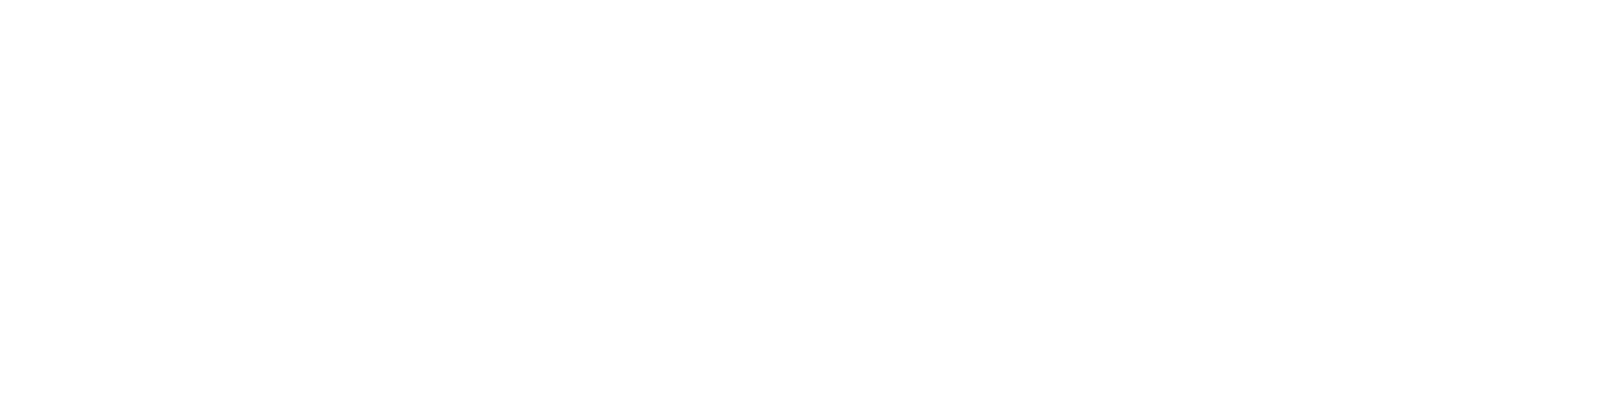

Iteration:  1


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 246.66it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.3 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


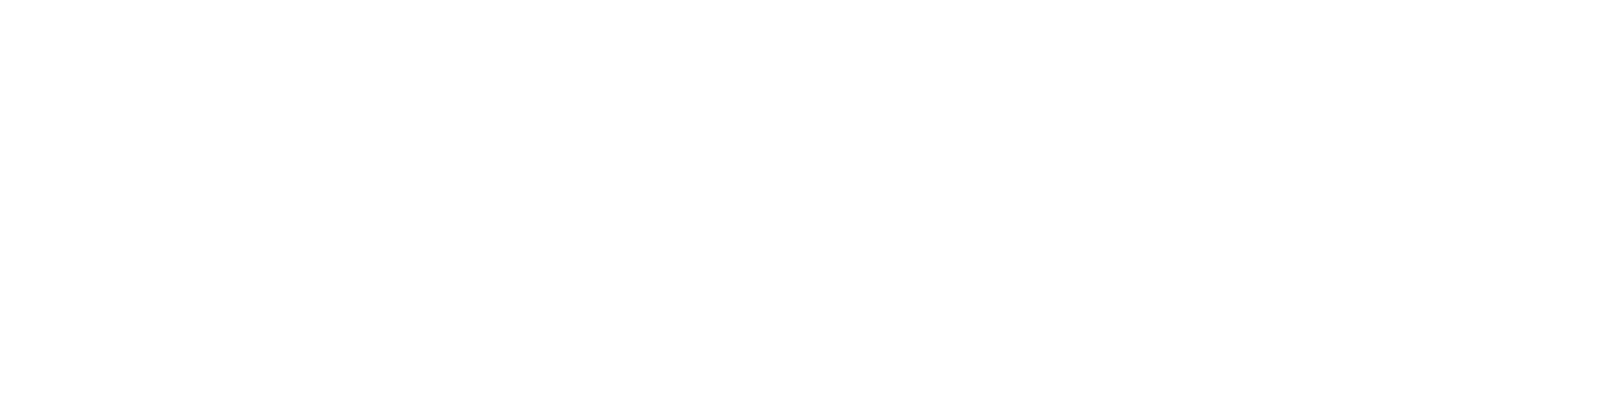

Iteration:  2


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 253.35it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.2 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


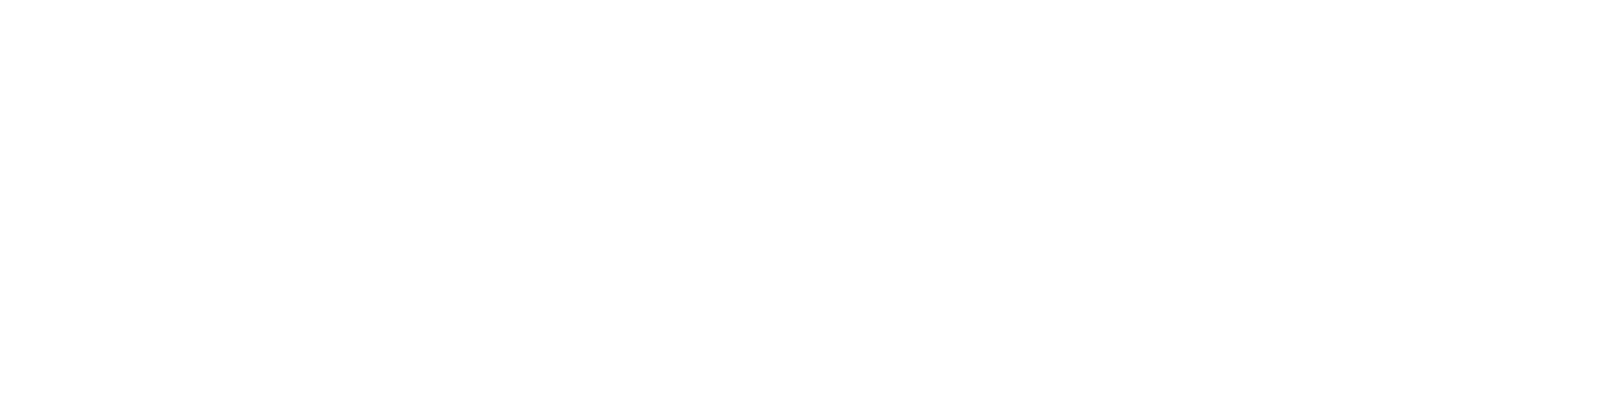

Iteration:  3


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 239.05it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.3 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


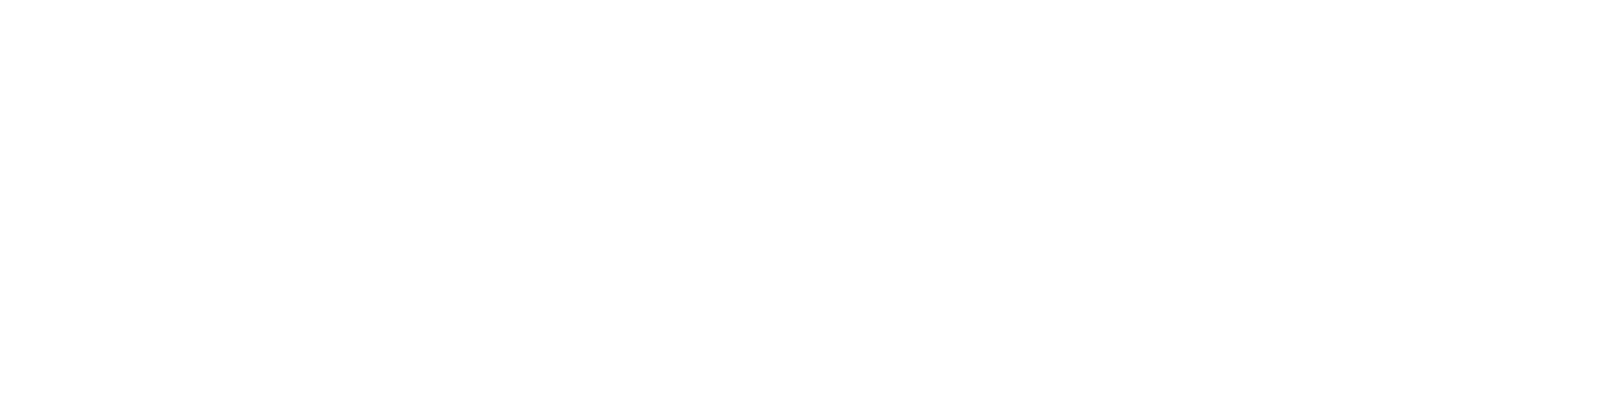

Iteration:  4


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 247.97it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.4 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


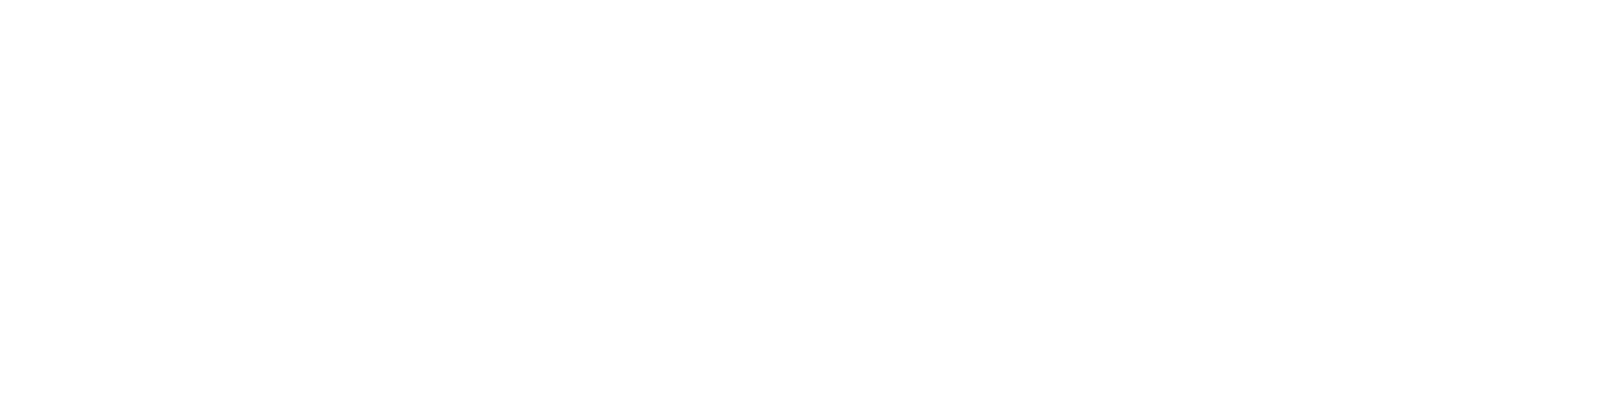

Iteration:  5


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 251.92it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.2 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


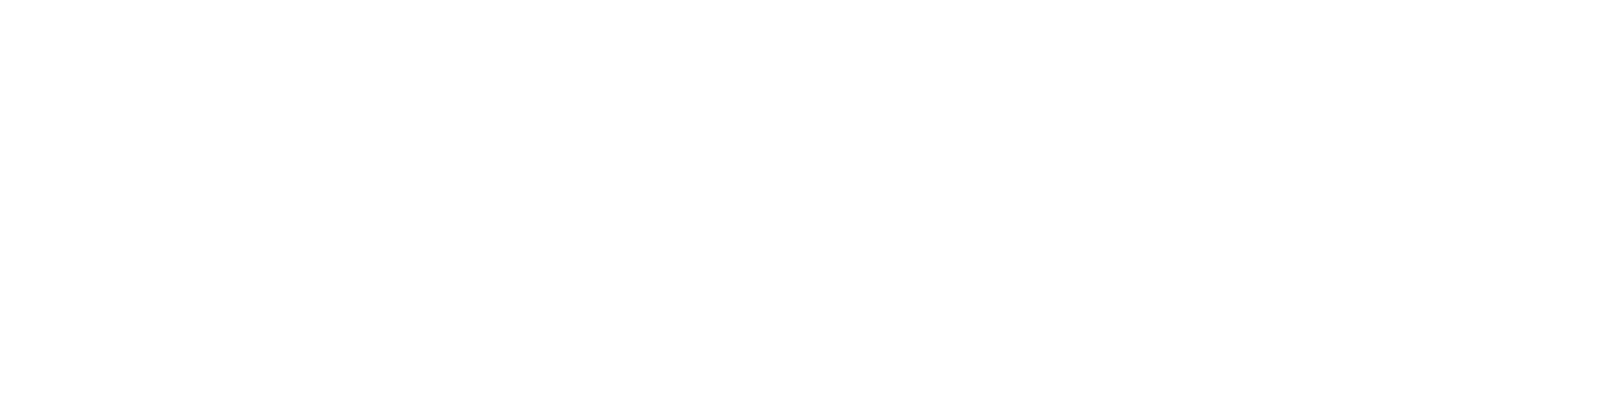

Iteration:  6


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 258.22it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.2 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


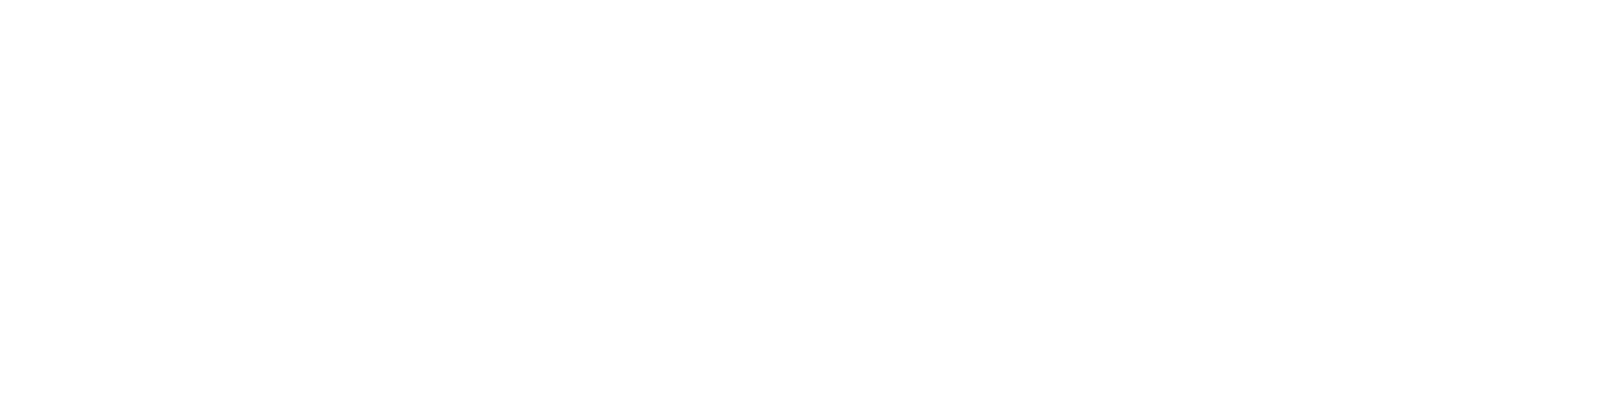

Iteration:  7


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 248.06it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.3 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


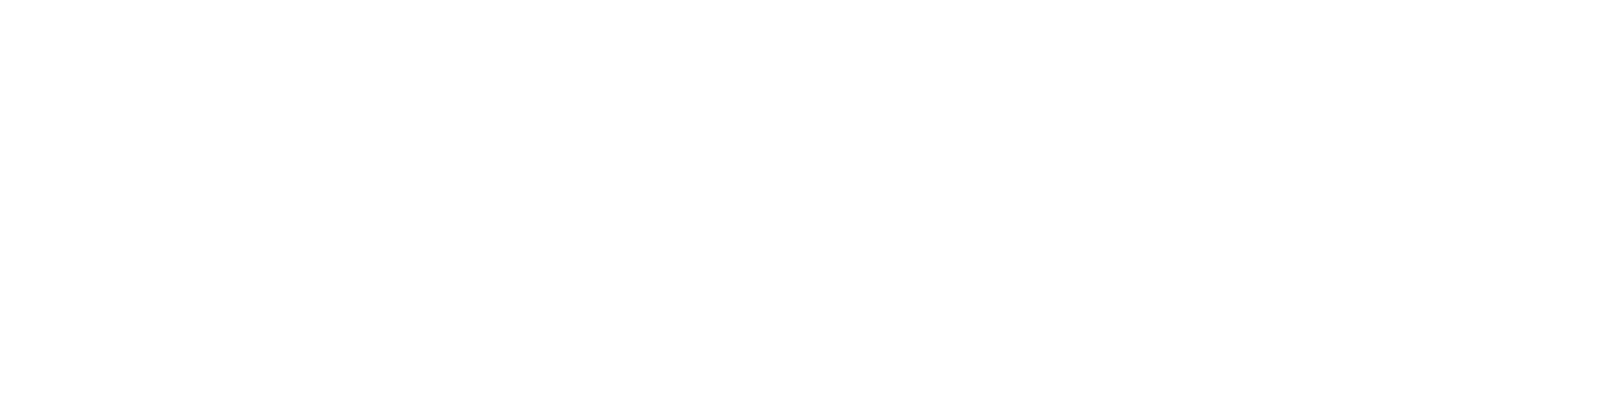

Iteration:  8


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 240.76it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.4 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


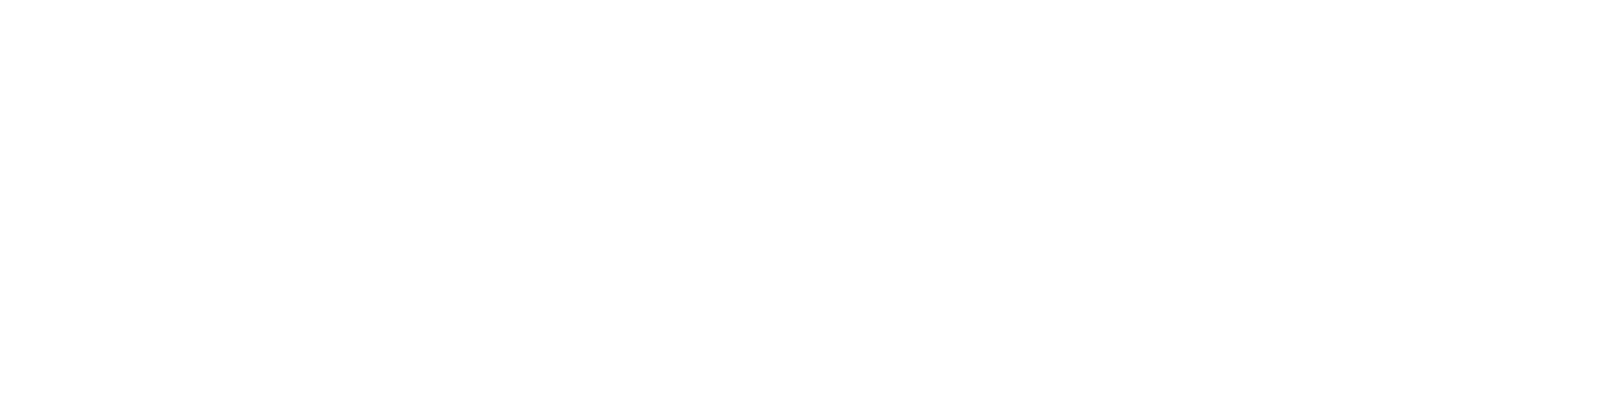

Iteration:  9


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 259.36it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=379)
Fit 2.2 s (n_proc=8, NOBJ=380)
Iterative correction - zeropoint / template


<IPython.core.display.Javascript object>


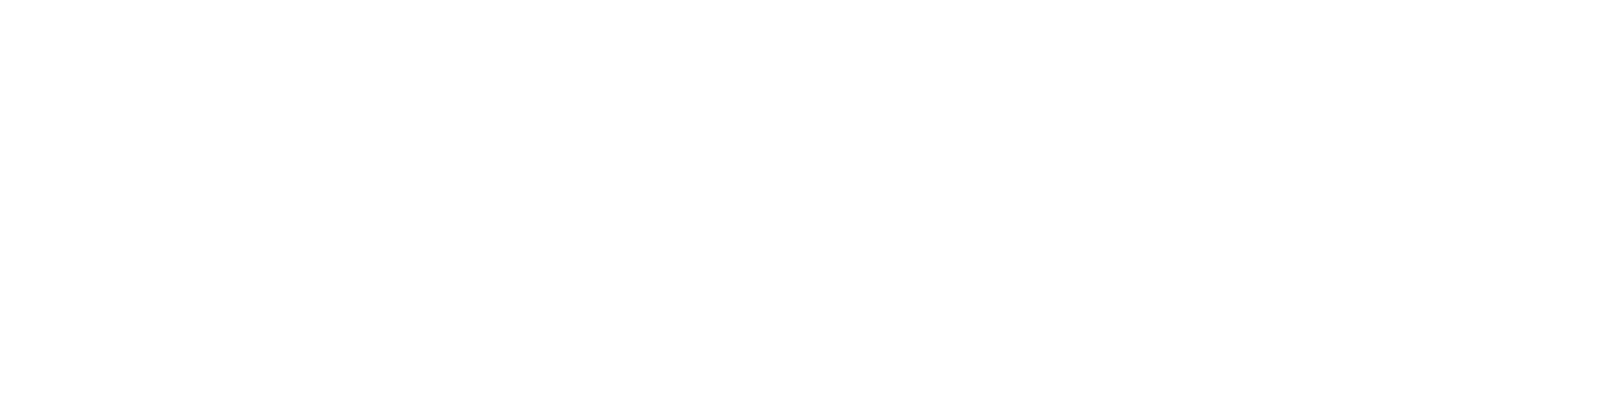

Set sys_err = 0.05 (positive=True)


100%|████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 244.51it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=382)
Fit 2.3 s (n_proc=8, NOBJ=383)
Get best fit coeffs & best redshifts
fit_best: 0.3 s (n_proc=1,  NOBJ=382)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


 23%|████████████████████▉                                                                     | 89/382 [00:01<00:03, 83.06it/s]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


100%|█████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:04<00:00, 76.48it/s]


 20%|██████████████████▏                                                                       | 77/382 [00:02<00:12, 24.92it/s]


 NNLS quitting on iteration count.


100%|█████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:15<00:00, 24.50it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:03<00:00, 99.43it/s]


In [9]:
pred = start_eazypy(param_file, params, NITER=10, translate_file=translate_files,
                    output_prefix="output.eazypy", dir_output=dir_output,
                    zeropoint_file=None)

# Saving the output EAZY model
with open("output.eazypy.zphot.pickle","wb") as fw:
    pickle.dump(pred, fw)

# 5. Evaluating the EAZY-py model
### photometric redshifts vs. spectroscopic redshifts

In [10]:
dz, hz = fits.getdata(dir_output+"output.eazypy.zout.fits", ext=1, header=True)

In [11]:
### Redshift comparison

c = 2.99792e+5    # km/s

def plot_comp(z_spec, z_phot, z_phot_chi2, out, ids,
              label_x='', label_y='', title='',
              z_clu=0.30, dv_mem=3000., xmin=0.03, xmax=30.0):
    z_cnd = ((z_phot > 0.) & (z_spec > 0.) & (z_phot_chi2 > 0.))
    z_mem = (c*np.abs(z_spec-z_clu)/(1+z_clu) < dv_mem)
    print(f"Objects : {np.sum(z_cnd):d}")
    print(f"Members : {np.sum(z_cnd & z_mem):d}")
    
    dz = np.abs(z_spec-z_phot)/(1+z_spec)
    # Normalized Median Absolute Deviation (NMAD)
    sigma = 1.48*np.median(np.abs(dz[z_cnd]-np.median(dz[z_cnd]))/(1+z_spec[z_cnd]))

    outlier = (z_cnd & (dz >= 0.15))
    print(f"Outliers: {np.sum(outlier):d}")
    print("\n")

    cmap = cm.get_cmap("jet")
    c_lo, c_hi = -1.5, 1.5
    norm = mpl.colors.Normalize(vmin=c_lo, vmax=c_hi)

    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(z_spec[z_cnd & ~z_mem], z_phot[z_cnd & ~z_mem], 'o', ms=3.0, mew=0.5,
            color='tab:blue', alpha=0.6)
    ax.plot(z_spec[z_cnd & z_mem],  z_phot[z_cnd & z_mem],  'o', ms=3.0, mew=0.5,
            color='tab:red', alpha=0.6)
    sym_1, = ax.plot(1.0e-10, 1.0e-10, 'o', ms=4.0, mew=0.8,
                     color='tab:blue', alpha=0.7, label="Spec-z sample")
    sym_2, = ax.plot(1.0e-10, 1.0e-10, 'o', ms=4.0, mew=0.8,
                     color='tab:red', alpha=0.7, label="Cluster member")
    ax.legend(handles=[sym_1, sym_2], fontsize=7.5, loc=(0.035, 0.035),
              handlelength=0, frameon=True, borderpad=0.8, handletextpad=0.8,
              framealpha=0.6, edgecolor='gray')
    ax.plot([xmin, xmax], [xmin, xmax], '-', lw=1.5, color='gray', alpha=0.75)
    xx = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
    ax.plot(xx, (1.0-0.15)*xx-0.15, '--', lw=1.2, color='gray', alpha=0.7)
    ax.plot(xx, (1.0+0.15)*xx+0.15, '--', lw=1.2, color='gray', alpha=0.7)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(label_x, fontsize=12.0)
    ax.set_ylabel(label_y, fontsize=12.0)
    ax.tick_params(axis='both', labelsize=12.0)
    ax.tick_params(width=1.5, length=7.5)
    ax.tick_params(width=1.5, length=4.0,which='minor')
    ax.text(0.05, 0.93, r"$N$"+f" = {np.sum(z_cnd):d} ({np.sum(outlier):d},"+ \
            f" {100.*np.sum(outlier)/np.sum(z_cnd):.1f}%)",
            fontsize=9.0, color="black",
            ha="left", va="top", transform=ax.transAxes)
    ax.text(0.05, 0.88, r"$\sigma_{\rm NMAD}$"+ \
            f" = {sigma:.3f}",
            fontsize=9.0, color="black",
            ha="left", va="top", transform=ax.transAxes)

    plt.tight_layout()
#     plt.savefig(out, dpi=300)
#     plt.close()

    return ids[outlier]

Objects : 381
Members : 178
Outliers: 32




<IPython.core.display.Javascript object>


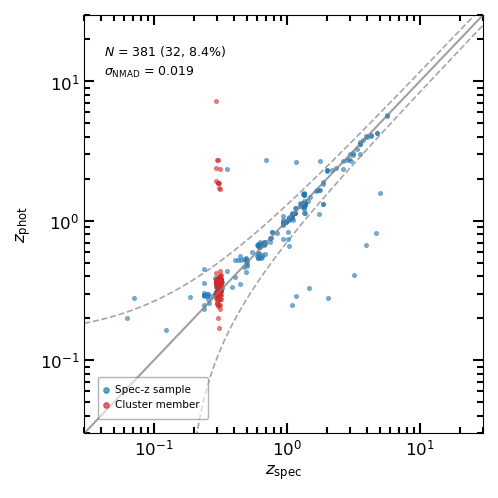

In [12]:
id_out = plot_comp(dz['z_spec'], dz['z_phot'], dz['z_phot_chi2'],
                   "Fig1-comp_z_eazypy.png", dz['id'],
                   label_x=r"$z_{\rm spec}$", label_y=r"$z_{\rm phot}$",
                   title="Phot-z from EAZY", z_clu=0.308, dv_mem=3000.,
                   xmin=0.03, xmax=30.0)

### Spectral energy distribution plot

  0%|                                                                                                     | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


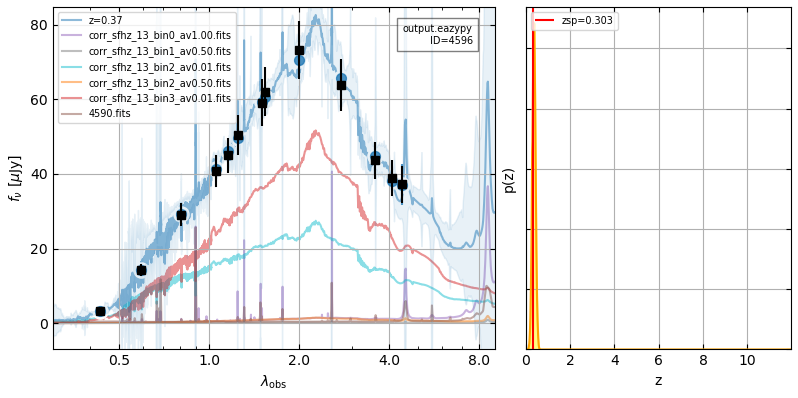

 20%|██████████████████▌                                                                          | 1/5 [00:00<00:02,  1.92it/s]

<IPython.core.display.Javascript object>


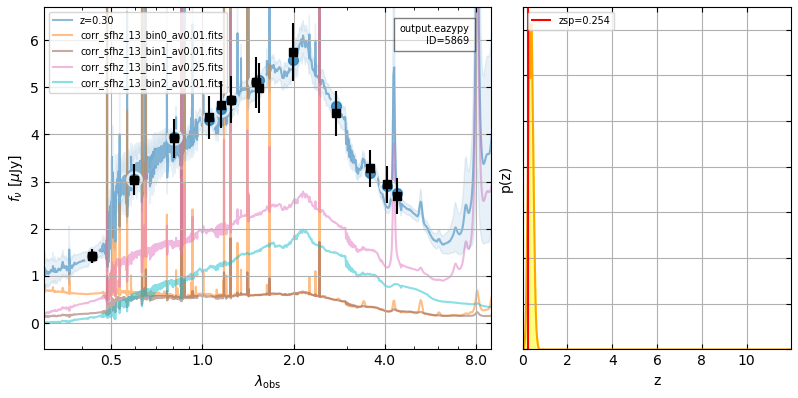

 40%|█████████████████████████████████████▏                                                       | 2/5 [00:01<00:01,  1.95it/s]

<IPython.core.display.Javascript object>


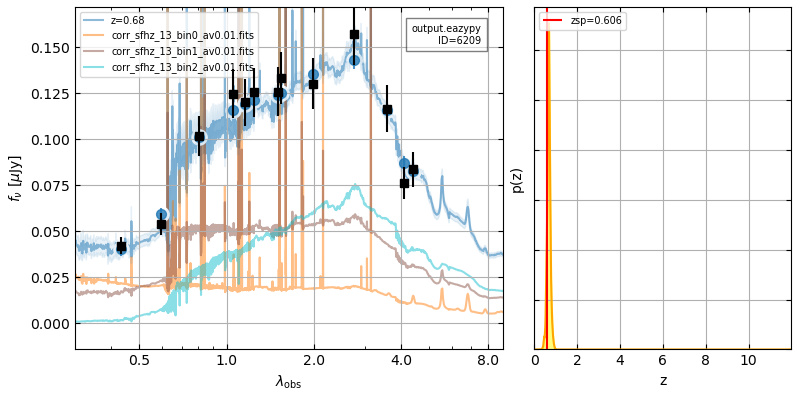

 60%|███████████████████████████████████████████████████████▊                                     | 3/5 [00:01<00:01,  1.98it/s]

<IPython.core.display.Javascript object>


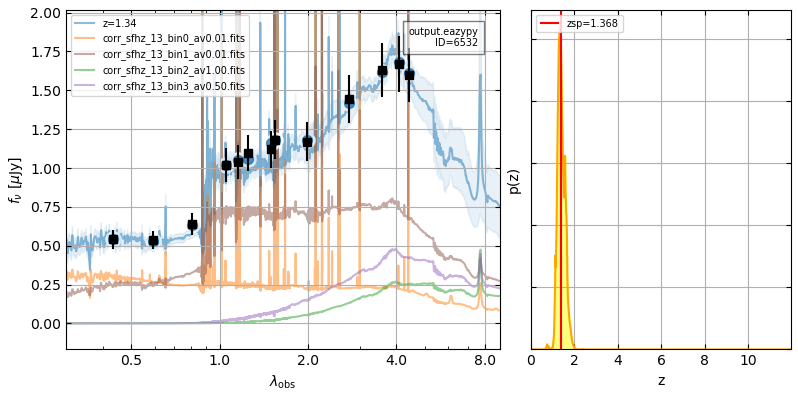

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4/5 [00:02<00:00,  1.82it/s]

<IPython.core.display.Javascript object>


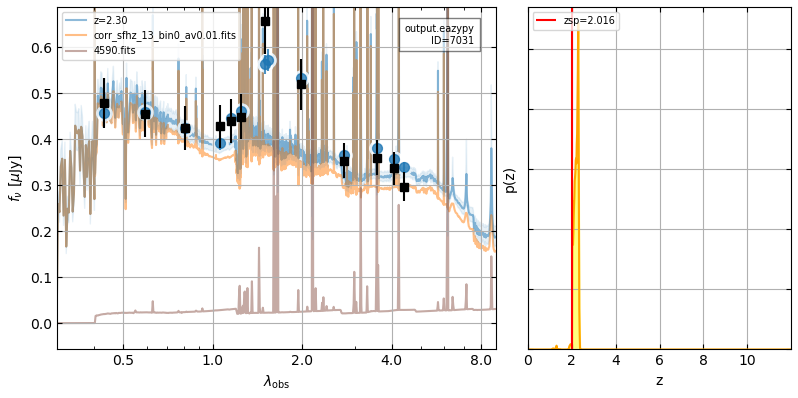

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


In [13]:
### SED plot

def plot_seds(dir_eazyout, output_fits, output_pickle, objids=None, save_data=False):
    
    if not (dir_eazyout[-1] == "/"):
        dir_eazyout += "/"

    dir_figs = dir_eazyout+"SED_EAZY/"
    if not os.path.exists(dir_figs):
        os.system("mkdir "+dir_figs)

    dz, hz = fits.getdata(dir_eazyout+output_fits, ext=1, header=True)

    with open(dir_eazyout+output_pickle, "rb") as fr:
        pred = pickle.load(fr)

    if objids is None:
        objids = dz['id']

#     objids = dz['id']
    n_obj = len(objids)

    for i in tqdm.trange(n_obj):
        objid = objids[i]
        fig, data = pred.show_fit(objid, id_is_idx=False, show_fnu=1,
                                  xlim=[0.3, 9], show_components=True)
        plt.savefig(dir_figs+f"ID-{objid:05d}.png", dpi=300)
#         plt.close()

        if save_data:
            with open(dir_figs+f"ID-{objid:05d}.data", "wb") as fw:
                pickle.dump(data, fw)                    

# Example: SEDs of the objects with the 10, 20, 30, 40, 50th IDs
plot_seds(dir_output, "output.eazypy.zout.fits", "output.eazypy.zphot.pickle",
          dz['id'][[10-1, 20-1, 30-1, 40-1, 50-1]], save_data=True)

In [14]:
dz['mass']

array([ 2.43719183e+10,  2.38556225e+10,  1.50024850e+10,  4.91847373e+10,
        2.50377398e+10,  2.33143612e+10,  4.64614034e+10,  3.84547001e+10,
        3.96624155e+09,  2.21142607e+10,  1.35605745e+11,  4.28913286e+10,
        1.78092298e+08,  3.35555238e+09,  1.71892287e+10,  1.95198968e+10,
        2.12496947e+08,  6.21750653e+07,  3.60116864e+10,  5.55676205e+08,
        2.81224187e+09,  1.00183322e+08,  1.40320465e+09,  5.08889311e+10,
        4.95856948e+08,  3.85825188e+08,  1.99779295e+10,  3.87813009e+07,
        2.55719921e+10,  7.25298391e+07,  2.81212650e+10,  7.41443849e+09,
        5.61576104e+08,  5.50399122e+10,  5.94777557e+10,  2.25195442e+09,
        1.04874324e+09,  6.93187566e+09,  2.28535615e+10,  4.10156670e+09,
        3.64409171e+08,  5.43715221e+07,  1.13792437e+10,  3.01712744e+09,
        4.28539842e+08,  4.54323727e+08,  9.89705327e+09,  1.29316939e+08,
        8.38425391e+09,  3.04929422e+08,  2.57349091e+09,  5.67789196e+08,
        1.27570998e+07,  